In [54]:
# merge background (reanalysis) and observation (regression estimates)

import numpy as np
from matplotlib import pyplot as plt
from scipy import io
import os
import sys
from optimal_interpolation import OImerge
import calendar
import auxiliary as au
from auxiliary_merge import *

########################################################################################################################

# time periods and methods
# y1 = int(sys.argv[1])
# y2 = int(sys.argv[2])
# vars = sys.argv[3]
# vars = [vars]
# month = int(sys.argv[4])
# year = [y1, y2]


y1 = 2018
y2 = 2018
vars = 'prcp'
vars = [vars]
month = 2
year = [y1, y2]
print('year:',year)

########################################################################################################################

# basic settings
weightmode = 'BMA' # method used to merge different reanalysis products
# vars = ['prcp', 'tmean', 'trange']
hwsize = 2  # 5X5 space window used to support estimation at the center grid
lontar = np.arange(-180 + 0.05, -50, 0.1)
lattar = np.arange(85 - 0.05, 5, -0.1)

# "Gaussian": prcp will be transformed into normal distributions; "Actual": actual space
# "Gaussian" is not a good choice because station prcp regression using box-cox has large underestimation
prcp_space = 'Actual'

### Local Mac settings
# input files/paths
path_bac = '/Users/localuser/Research/EMDNA/merge' # data that will be used as background
path_obs = '/Users/localuser/Research/EMDNA/regression' # data that will be used as observation
near_file_GMET = '/Users/localuser/Research/EMDNA/regression/weight_nearstn.npz' # near station of stations/grids
file_mask = './DEM/NA_DEM_010deg_trim.mat'
FileStnInfo = '/Users/localuser/GMET/pyGMET_NA/stnlist_whole.txt'
gmet_stndatafile = '/Users/localuser/Research/EMDNA/stndata_whole.npz'

# output files/paths (can also be used as inputs once generated)
path_oimerge = '/Users/localuser/Research/EMDNA/oimerge'

### Local Mac settings


# ### Plato settings
# # input files/paths
# path_bac = '/home/gut428/ReanalysisCorrMerge/Reanalysis_merge'
# path_obs = '/datastore/GLOBALWATER/CommonData/EMDNA/PyGMETout'
# near_file_GMET = '/datastore/GLOBALWATER/CommonData/EMDNA/PyGMETout/weight.npz'
# file_mask = '/datastore/GLOBALWATER/CommonData/EMDNA/DEM/NA_DEM_010deg_trim.mat'
# FileStnInfo = '/home/gut428/GMET/eCAI_EMDNA/StnGridInfo/stnlist_whole.txt'
# gmet_stndatafile = '/datastore/GLOBALWATER/CommonData/EMDNA/stndata_whole.npz'
#
# # output files/paths (can also be used as inputs once generated)
# path_oimerge = '/home/gut428/OImerge'
# ### Plato settings

file_regression_stn = path_obs + '/daily_regression_stn.npz'
file_corrmerge_stn = [''] * len(vars)
for i in range(len(vars)):
    file_corrmerge_stn[i] = path_bac + '/mergecorr_stn_' + vars[i] + '_GWRQM_' + weightmode + '.npz'

########################################################################################################################

# basic processing
mask = io.loadmat(file_mask)
mask = mask['DEM']
mask[~np.isnan(mask)] = 1  # 1: valid pixels
nrows, ncols = np.shape(mask)

# date
date_list, date_number = m_DateList(1979, 2018, 'ByYear')

# stninfo
stnID, stninfo = au.readstnlist(FileStnInfo)
nstn = len(stnID)


year: [2018, 2018]


In [46]:
for v in range(len(vars)):
    print('OI merge at stations:', vars[v])

    # load station original observations
    datatemp = np.load(gmet_stndatafile)
    observation_stn = datatemp[vars[v]+'_stn']
    del datatemp

    # load station regression estimates (obs)
    datatemp = np.load(file_regression_stn)
    regression_stn = datatemp[vars[v]]
    del datatemp

    # load corrected/merged reanalysis data at all station points (those are totally independent with station observations)
    datatemp = np.load(file_corrmerge_stn[v])
    reafinal_stn = datatemp['reamerge_stn']
    nstn, ntimes = np.shape(reafinal_stn)
    del datatemp

    # load near station information
    datatemp = np.load(near_file_GMET)
    if vars[v] == 'prcp':
        near_loc = datatemp['near_grid_prcpLoc']
        near_weight = datatemp['near_grid_prcpWeight']
        near_dist = datatemp['near_grid_prcpDist']
    else:
        near_loc = datatemp['near_grid_tempLoc']
        near_weight = datatemp['near_grid_tempWeight']
        near_dist = datatemp['near_grid_tempDist']
    near_loc = np.flipud(near_loc)
    near_weight = np.flipud(near_weight)
    near_dist = np.flipud(near_dist)
    del datatemp

    # load OI merged data at station points
    filemerge_stn = path_oimerge + '/OImerge_stn_GWRQMBMA_' + vars[v] + '.npz'
    datatemp = np.load(filemerge_stn)
    oimerge_stn = datatemp['oimerge_stn']
    del datatemp

    # start OI merging
    for m in range(month-1, month):
        print('month', m + 1)
        indm = (date_number['mm'] == m + 1)
        nday = sum(indm)
        datem = date_number['yyyy'][indm]

        # load gridded merged reanalysis data for all years
        print('load gridded merged data')
        reagrid_value = np.nan * np.zeros([nrows, ncols, nday], dtype=np.float32)
        reagrid_error = np.nan * np.zeros([nrows, ncols, nday], dtype=np.float32)
        for y in range(2018, 2019):
            indym = datem == y
            filey = path_bac + '/bmamerge_' + vars[v] + '_' + str(y*100+m+1) + '.npz'
            datatemp = np.load(filey)
            reagrid_value[:, :, indym] = datatemp['bma_data']
            reagrid_error[:, :, indym] = datatemp['bma_error']
            del datatemp


        # calculate OI-merging weights for every grids
        print('calculate OI merging weights')
        file_oiweight = path_oimerge + '/oiweight_' + vars[v] + '_month_' + str(m+1) + '.npz'
        if os.path.isfile(file_oiweight):
            datatemp = np.load(file_oiweight)
            oiweight = datatemp['oiweight']
            del datatemp
        else:
            oiweight = np.nan * np.zeros([nrows, ncols, np.shape(near_loc)[2]], dtype=np.float32)
            for r in range(nrows):
                if np.mod(r,50)==0:
                    print(r)
                for c in range(ncols):
                    if np.isnan(mask[r, c]):
                        continue
                    near_loci = near_loc[r, c, :]
                    near_loci = near_loci[near_loci > -1]

                    b_near = reafinal_stn[near_loci, :][:, indm]
                    o_near = regression_stn[near_loci, :][:, indm]
                    # this error is from weighted mean. if using nearest neighbor to obtain gridded error, this weight will be more similar to stn-OI
                    tar_err_b = reagrid_error[r, c, :]
                    near_err_b = b_near - observation_stn[near_loci, :][:, indm]
                    near_err_o = o_near - observation_stn[near_loci, :][:, indm]

                    # delete possible nan values
                    induse = ~np.isnan(tar_err_b + np.sum(near_err_b, axis=0) + np.sum(near_err_o, axis=0))
                    weight = OImerge(tar_err_b[induse], near_err_b[:, induse], near_err_o[:, induse], eye_o=0)

                    oiweight[r, c, 0:len(weight)] = weight
            np.savez_compressed(file_oiweight, oiweight=oiweight)

OI merge at stations: prcp
month 2
load gridded merged data
calculate OI merging weights


In [55]:
        # perform OI merging for all years
        print('perform OI merging')
        for y in range(2018, 2019):
            fileoi_ym = path_oimerge + '/oimerge_' + vars[v] + str(y*100+m+1) + '.npz'
            indym1 = datem == y
            ndayy = np.sum(indym1)
            indym2 = (date_number['mm'] == m + 1) & (date_number['yyyy'] == y)
            if os.path.isfile(fileoi_ym):
                continue

            # calculate OI value
            oi_value = np.nan * np.zeros([nrows, ncols, ndayy], dtype=np.float32)
            for r in range(nrows):
                for c in range(ncols):
                    if np.isnan(mask[r, c]):
                        continue
                    near_loci = near_loc[r, c, :]
                    near_loci = near_loci[near_loci > -1]

                    weight = oiweight[r, c, :]
                    weight = weight[~np.isnan(weight)]
                    if (np.any(np.isnan(weight))) or (np.any(abs(weight) > 2)): # exclude too large values
                        weight = near_weight[r, c, 0:len(weight)]
                        weight = weight / np.sum(weight)

                    b_tar = reagrid_value[r, c, indym1]
                    b_near = reafinal_stn[near_loci, :][:, indym2]
                    o_near = regression_stn[near_loci, :][:, indym2]

                    diff = o_near - b_near
                    merge_est = b_tar.copy()
                    for id in range(ndayy):
                        merge_est[id] = merge_est[id] + np.dot(weight, diff[:, id])
                    oi_value[r, c, :] = merge_est

            # calculate OI error (mean square error from nearby stations)
            oi_error_stn = (oimerge_stn[:, indym2] - observation_stn[:, indym2]) ** 2
            oi_mse = extrapolation(oi_error_stn, near_loc, near_dist)

            np.savez_compressed(fileoi_ym, oi_value=oi_value, oi_mse=oi_mse)

perform OI merging


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


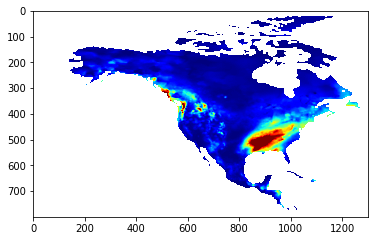

In [56]:
plt.imshow(np.nanmean(oi_value,axis=2),cmap='jet')
plt.clim([0,10])